In [1]:
# Import Data handling/display libraries
import pandas  as pd
import numpy   as np
import seaborn as sns
sns.set()
sns.set_context("talk")
import matplotlib.pyplot as plt
from IPython.display import display
from typing import List, Union, Dict
# Import scikit-learn core slibraries
from sklearn.metrics         import auc, roc_auc_score, roc_curve
from sklearn.metrics         import classification_report, confusion_matrix
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from collections             import Counter
from IPython.display         import Markdown, display
# Import IBM's AI Fairness tooolbox
from aif360.datasets   import BinaryLabelDataset  # To handle the data
from aif360.metrics    import BinaryLabelDatasetMetric, ClassificationMetric, DatasetMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms import Transformer
from aif360.algorithms.preprocessing import DisparateImpactRemover # Preprocessing technique
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned Adult dataset
Adult_df = pd.read_csv('./input/adult-cleaned.csv')

In [3]:
# The AIF demo drops the following columns - we'll try the same
#Adult_df.drop(["Fnlwgt", "NativeCountry", "Relationship", "MaritalStatus"],axis=1,inplace=True)
Adult_df.drop(["Fnlwgt"],axis=1,inplace=True)

In [4]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'Gender'
priv_grp            = 1  # Males 
unpriv_grp          = 0  # Females  
lab                 = 'Income'
fav_label           = 1 # Income over £50K
unfav_label         = 0 # Income under £50K
privileged_groups   = [{protected_attr: priv_grp}]   # Males
unprivileged_groups = [{protected_attr: unpriv_grp}] # Females

In [5]:
# Create a Binary Label Dataset to use with AIF360 APIs
X = Adult_df.drop(lab,axis=1)
y = Adult_df[lab]

In [6]:
Adult_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)

In [7]:
# Create train and test datasets
Adult_train_bld, Adult_test_bld = Adult_bld.split([0.8], shuffle=True, seed=101)

In [8]:
scaler = MinMaxScaler(copy=False)
Adult_train_bld.features = scaler.fit_transform(Adult_train_bld.features)
Adult_test_bld.features  = scaler.fit_transform(Adult_test_bld.features)

In [9]:
Adult_train_df, d = Adult_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
Adult_test_df,  d = Adult_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [10]:
# First test whether it is possible to predict the Sensitive Variable from the whole original dataset
X_se_train = Adult_train_df.drop(protected_attr,axis=1)
y_se_train = Adult_train_df[protected_attr]
X_se_test  = Adult_test_df.drop(protected_attr,axis=1)
y_se_test  = Adult_test_df[protected_attr]

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.7607738765482649
Biased Random Forest       validation accuracy: 0.8003889855665882

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.6952920907607211
Biased Random Forest       balanced accuracy  : 0.7569811626718649


In [11]:
# Next get the number of labels from the training dataset
print('Training Before - Income value counts:')
print(Adult_train_df.Income.value_counts())
print('Training Before - Gender value counts:')
print(Adult_train_df.Gender.value_counts())

Training Before - Income value counts:
0.0    29750
1.0     9323
Name: Income, dtype: int64
Training Before - Gender value counts:
1.0    26143
0.0    12930
Name: Gender, dtype: int64


In [12]:
# Determine the baseline model accuracy for Logistic Regression and Random Forest Classifiers
X_train = Adult_train_df.drop(lab,axis=1)
y_train = Adult_train_df[lab]
X_test  = Adult_test_df.drop(lab,axis=1)
y_test  = Adult_test_df[lab]

BiasedLogModel = LogisticRegression(random_state=101)
BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)

BiasedLogModel.fit(X_train, y_train) 
BiasedRfcModel.fit(X_train, y_train)

BiasedLogPredictions = BiasedLogModel.predict(X_test)
BiasedRfcPredictions = BiasedRfcModel.predict(X_test)
print(f"Biased Logistic regression validation accuracy: {BiasedLogModel.score(X_test, y_test)}")
print(f"Biased Random Forest       validation accuracy: {BiasedRfcModel.score(X_test, y_test)}")
print('')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test, BiasedLogPredictions)}")
print(f"Biased Random forest balanced accuracy        : {balanced_accuracy_score(y_test, BiasedRfcPredictions)}")

Biased Logistic regression validation accuracy: 0.8195311700276384
Biased Random Forest       validation accuracy: 0.8344764049544477

Biased Logistic regression balanced accuracy  : 0.6914758971792736
Biased Random forest balanced accuracy        : 0.6781526807126022


In [13]:
# Create the binary label dataset metric class for the training dataset
metric_train_bld = BinaryLabelDatasetMetric(Adult_train_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print("Base Rate                     :%f" % metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))
display(Markdown("#### Biased training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

#### Biased training dataset

Number of instances           : 39073.0
Base Rate                     :0.238605
Consistency                   : [0.83263123]
Disparate Impact              : 0.3620832314871518
Mean Difference               : -0.19293913814906824
Statistical Parity Difference : -0.19293913814906824
# of positives(privileged)    : 7907.0
# of positives(non-privileged): 1416.0
Total positive instances"     : 9323.0
# of negatives(privileged)    : 18236.0
# of negatives(non-privileged): 11514.0
Total negative instances"     : 29750.0


#### Biased training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.192939


In [14]:
#Test for equality of odds. 
Test_Log_bld = Adult_test_bld.copy(deepcopy=True)
Test_Rfc_bld = Adult_test_bld.copy(deepcopy=True)
TestLogPredictions = BiasedLogModel.predict(X_test)
TestRfcPredictions = BiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(Adult_test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Adult_test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [15]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.17240932599510445
Log average_odds_difference:     -0.17240932599510445
 
Rfc average_abs_odds_difference: 0.10648112965040518
Rfc average_odds_difference:     -0.10648112965040518


In [16]:
from tqdm import tqdm
index = Adult_train_bld.feature_names.index(protected_attr)
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(Adult_train_bld)
    test_repd = di.fit_transform(Adult_test_bld)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=101)
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    DIs.append(cm.disparate_impact())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:17<00:00, 10.14s/it]


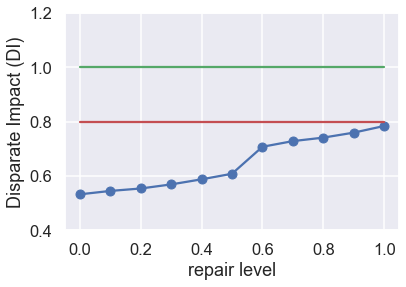

In [17]:
%matplotlib inline
plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()

In [18]:
# Where the plot meets the 0.8 (threshold) line is where we target, eg level = 1.0
# Therefore set up an instance of the disparate remover object using this repair level
di = DisparateImpactRemover(repair_level=1.0)
Adult_di_train_bld = di.fit_transform(Adult_train_bld)
Adult_di_test_bld  = di.fit_transform(Adult_test_bld)

In [19]:
# Train Logistic and Random Forest classifiers with the transformed dataset.
X_di_train = np.delete(Adult_di_train_bld.features,index, axis=1) # Drop Gender! This is what the AIF360 example does
X_di_test  = np.delete(Adult_di_test_bld.features, index, axis=1) # thus we cannot compare before and after feature 
y_di_train = Adult_di_train_bld.labels.ravel()                    # importance, and binary label dataset metrics because
y_di_test  = Adult_di_test_bld.labels.ravel()                     # the sensitive attr has been dropped. Doh!

Di_LogModel= LogisticRegression(class_weight='balanced', solver='liblinear', random_state=101)
Di_RfcModel= RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)

Di_LogModel.fit(X_di_train, y_train)
Di_RfcModel.fit(X_di_train, y_train)

Di_train_LogPredictions= Di_LogModel.predict(X_di_train) 
Di_train_RfcPredictions= Di_RfcModel.predict(X_di_train)
Di_test_LogPredictions = Di_LogModel.predict(X_di_test) 
Di_test_RfcPredictions = Di_RfcModel.predict(X_di_test)

# Now test whether we can predict Gender from the test dataset
print('Model Accuracy after DI removed:')
print(f"Unbiased Logistic regression validation accuracy: {Di_LogModel.score(X_di_test, y_di_test)}")
print(f"Unbiased Random Forest       validation accuracy: {Di_RfcModel.score(X_di_test, y_di_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Unbiased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test, Di_test_LogPredictions)}")
print(f"Unbiased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_test, Di_test_RfcPredictions)}")

Model Accuracy after DI removed:
Unbiased Logistic regression validation accuracy: 0.7376394717985464
Unbiased Random Forest       validation accuracy: 0.8381615313747569

Biased Balanced accuracy
Unbiased Logistic regression balanced accuracy  : 0.7330637025561226
Unbiased Random Forest       balanced accuracy  : 0.7092362822485836


In [20]:
Adult_di_test_bld_cpy        = Adult_di_test_bld.copy()
Adult_di_test_bld_cpy.labels = Di_test_LogPredictions

Adult_di_train_bld_cpy       = Adult_di_train_bld.copy()
Adult_di_train_bld_cpy.labels= Di_train_LogPredictions

metric_train_bld = BinaryLabelDatasetMetric(Adult_di_test_bld_cpy, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print("Base Rate                     :%f" % metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))
display(Markdown("#### Biased training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

#### Biased training dataset

Number of instances           : 9769.0
Base Rate                     :0.370867
Consistency                   : 0.9120073702528398
Disparate Impact              : 0.7838038522654707
Mean Difference               : -0.08641865379706637
Statistical Parity Difference : -0.08641865379706637
# of positives(privileged)    : 2601.0
# of positives(non-privileged): 1022.0
Total positive instances"     : 3623.0
# of negatives(privileged)    : 3906.0
# of negatives(non-privileged): 2240.0
Total negative instances"     : 6146.0


#### Biased training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.086419


In [21]:
Adult_di_train_df,d = Adult_di_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
Adult_di_test_df, d = Adult_di_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [22]:
# Test for Equality of Odds
Adult_Log_di_test_bld        = Adult_di_test_bld.copy()
Adult_Rfc_di_test_bld        = Adult_di_test_bld.copy()

Adult_Log_di_test_bld.labels = Di_test_LogPredictions
Adult_Rfc_di_test_bld.labels = Di_test_RfcPredictions

c_Log_metric = ClassificationMetric(Adult_di_test_bld, Adult_Log_di_test_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Adult_di_test_bld, Adult_Rfc_di_test_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [23]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.040742589192332784
Log average_odds_difference:     -0.021335246169269045
 
Rfc average_abs_odds_difference: 0.1507083841348042
Rfc average_odds_difference:     -0.1507083841348042


In [24]:
# Let's take a look at the differences between the original dataset and the DI_removed dataset
Adult_train_df   = Adult_train_df.reset_index(drop=True)
Adult_di_train_df= Adult_di_train_df.reset_index(drop=True)
AdultBool        = (Adult_train_df != Adult_di_train_df).stack()  # Create Frame of comparison booleans
Adultdiff        = pd.concat([Adult_train_df.stack()[AdultBool], Adult_di_train_df.stack()[AdultBool]], axis=1)
Adultdiff.columns=["Adult_train_df", "Adult_di_train_df"]
print(Adultdiff)

                    Adult_train_df  Adult_di_train_df
1     HoursPerWeek        0.397959           0.336735
3     Occupation          0.692308           0.615385
      HoursPerWeek        0.551020           0.459184
4     Occupation          0.538462           0.461538
      HoursPerWeek        0.500000           0.418367
5     Age                 0.575342           0.561644
      HoursPerWeek        0.295918           0.244898
6     Age                 0.712329           0.698630
      HoursPerWeek        0.122449           0.102041
8     Occupation          0.538462           0.461538
      HoursPerWeek        0.448980           0.377551
9     Occupation          0.615385           0.538462
      HoursPerWeek        0.397959           0.336735
10    Occupation          0.692308           0.615385
      HoursPerWeek        0.040816           0.030612
11    Age                 0.493151           0.479452
      HoursPerWeek        0.397959           0.336735
13    Occupation          0.

Accuracy:


,LogReg,RFC
Biased,0.819531,0.834476
Fair,0.737639,0.838162


AUC:


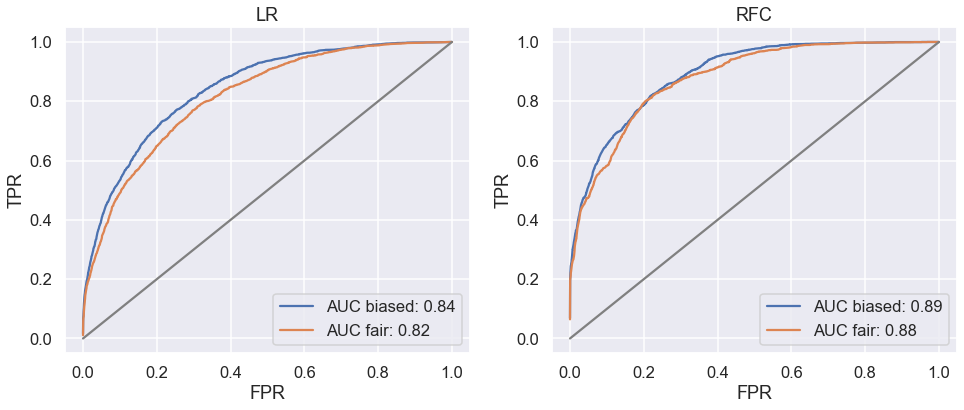

In [25]:
%matplotlib inline
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray], title: str='', ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, y=tpr, ci=None, ax=ax)
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray',ax=ax)
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [BiasedLogModel.score(X_test, y_test), 
                                 Di_LogModel.score(X_di_test, y_di_test)],
                      'RFC': [BiasedRfcModel.score(X_test, y_test),
                              Di_RfcModel.score(X_di_test, y_di_test)]}, 
                      index =['Biased', 'Fair']))

print('AUC:')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
plot_auc(y_test, 
         {'AUC biased': BiasedLogModel.predict_proba(X_test)[:, 1], 
          'AUC fair'  : Di_LogModel.predict_proba(X_di_test)[:, 1]},
         title='LR', ax=ax[0]) 
plot_auc(y_test, 
         {'AUC biased': BiasedRfcModel.predict_proba(X_test)[:, 1],
          'AUC fair'  : Di_RfcModel.predict_proba(X_di_test)[:, 1]},
         title='RFC', ax=ax[1]) 
plt.show()

In [26]:
# Finally test whether it is possible to predict the Sensitive Variable from the transformed dataset
X_se_train = Adult_di_train_df.drop(protected_attr,axis=1)
y_se_train = Adult_di_train_df[protected_attr]
X_se_test  = Adult_di_test_df.drop(protected_attr,axis=1)
y_se_test  = Adult_di_test_df[protected_attr]

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.6649605896202273
Biased Random Forest       validation accuracy: 0.7480806633227557

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.5509809885444312
Biased Random Forest       balanced accuracy  : 0.6635963279464072


In [27]:
# Lastly get the number of labels from the modified training dataset
print('Training Before - Income value counts:')
print(Adult_di_train_df.Income.value_counts())
print('Training Before - Gender value counts:')
print(Adult_di_train_df.Gender.value_counts())

Training Before - Income value counts:
0.0    29750
1.0     9323
Name: Income, dtype: int64
Training Before - Gender value counts:
1.0    26143
0.0    12930
Name: Gender, dtype: int64


In [28]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier], names: List[str],scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names, 'importance': imp,
                         'std': var}).sort_values('importance', ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

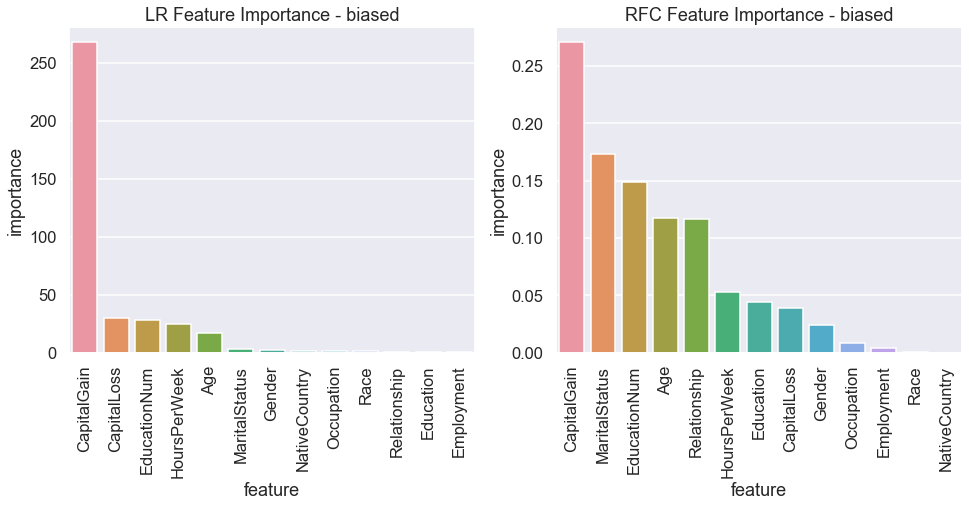

In [29]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedLogModel, names=X_train.columns.tolist(),
                                                scale=X_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - biased')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedRfcModel, names=X_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - biased')

In [30]:
Adult_di_bld = di.fit_transform(Adult_bld)
Adult_di_train_bld, Adult_di_test_bld = Adult_di_bld.split([0.8], shuffle=True, seed=101)

scaler = MinMaxScaler(copy=False)
Adult_di_train_bld.features = scaler.fit_transform(Adult_di_train_bld.features)
Adult_di_test_bld.features  = scaler.fit_transform(Adult_di_test_bld.features)

Adult_di_train_df, d = Adult_di_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
Adult_di_test_df,  d = Adult_di_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

X_di_train = Adult_di_train_df.drop(lab,axis=1)
y_di_train = Adult_di_train_df[lab]
X_di_test  = Adult_di_test_df.drop(lab,axis=1)
y_di_test  = Adult_di_test_df[lab]

UnbiasedLogmodel = LogisticRegression(random_state=101)
UnbiasedLogmodel.fit(X_di_train,y_di_train)
logpredictions = UnbiasedLogmodel.predict(X_di_test)
# Now train Random Forest Classifier to establish the DI_Removed performance
UnbiasedRfcmodel = RandomForestClassifier(n_estimators=100, max_depth=4)
UnbiasedRfcmodel.fit(X_di_train, y_di_train) 
rfcpredictions = UnbiasedRfcmodel.predict(X_di_test)

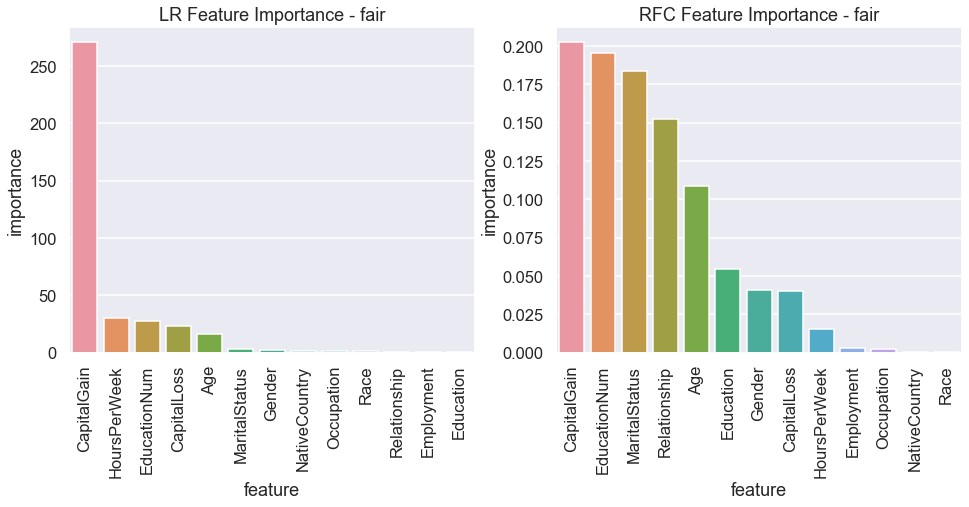

In [31]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedLogmodel, names=X_di_train.columns.tolist(), 
                                                scale=X_di_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - fair')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedRfcmodel, names=X_di_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - fair')

In [32]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true), axis=1),
                                  label_names=[lab],
                                  protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label,
                                  unfavorable_label=unfav_label)
    
    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy = []
    balanced_accuracy = []
    disp_impact = []
    average_abs_odds_difference = []
    avg_odd_diff = []
    equal_opportunity_difference = []
    error_rate = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
#        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        disp_impact.append(np.abs(valid_metric.disparate_impact()))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate},
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

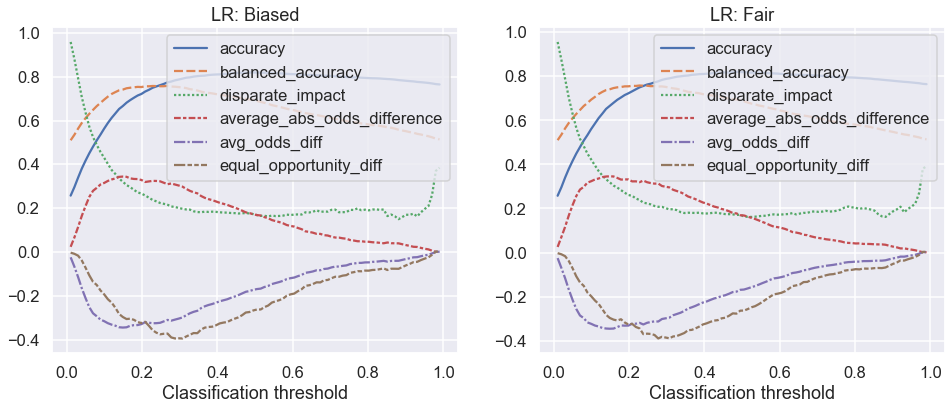

In [33]:
# Plot for Logistic Regression Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
with warnings.catch_warnings():
     warnings.simplefilter('ignore', RuntimeWarning)
    
     plot_metrics(calc_metrics(BiasedLogModel, X_test, y_test), ax=ax[0], title="LR: Biased")
 
     plot_metrics(calc_metrics(UnbiasedLogmodel, X_di_test, y_di_test), ax=ax[1], title="LR: Fair")

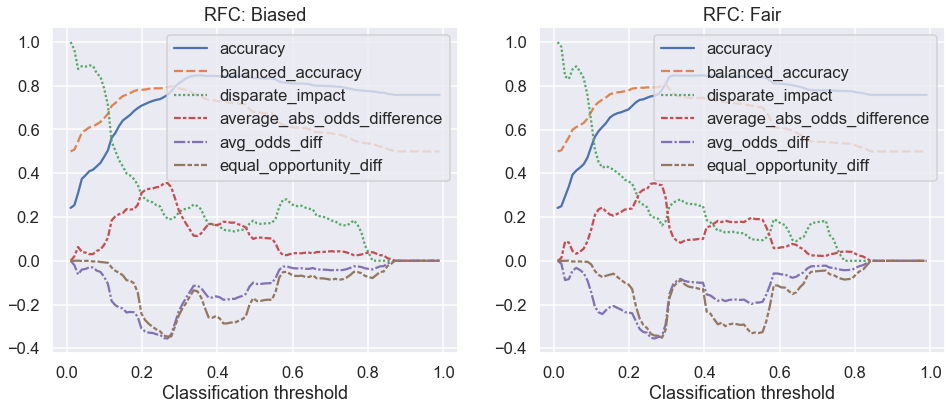

In [34]:
# Plot for Random Forest Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(BiasedRfcModel, X_test, y_test), ax=ax[0], title="RFC: Biased")
    
    plot_metrics(calc_metrics(UnbiasedRfcmodel, X_di_test, y_di_test), ax=ax[1], title="RFC: Fair")